# Linear regression

files needed = ('sleep75.dta', 'wage1.dta')

This notebook introduces us to the statsmodels package [(docs)](https://devdocs.io/statsmodels/), which provides functions for formulating and estimating statistical models. This notebook will not address the models, per se, but will focus on how to put econometrics to work in python.

Many of you have used STATA before. STATA is a great package for econometrics. Python can do most of what STATA can do, but STATA will have more specialized routines available. As python's popularity grows the kinds of models you can estimate in grows, too.    

If STATA is your thing, this [page](http://rlhick.people.wm.edu/posts/comparing-stata-and-ipython-commands-for-ols-models.html) on Rob Hicks' website is a nice STATA to python concordance.  

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting


# The new packages...
import patsy                           # provides a syntax for specifying models  
import statsmodels.api as sm           # provides statistical models like ols, gmm, anova, etc...
import statsmodels.formula.api as smf  # provides a way to directly spec models from formulas

### Reading Stata data files

Jeff Wooldridge's econometrics textbooks are an academic staple. Our plan today is to work through some of the problems in the Wooldridge textbook as a way to introduce regression in python. 

On the plus side, the data that correspond to the Wooldridge problems are available to download and they are **ALREADY CLEANED.** \[I contemplated adding some junk to the files to make it more interesting...\]

On the minus side, the files are in STATA's .dta format. 

Lucky for us, pandas has a method that [reads stata files](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_stata.html). It also has methods for SQL, SAS, JSON,...

In [2]:
# Use pandas read_stata method to get the stata formatted data file into a DataFrame.
sleep = pd.read_stata('sleep75.dta')

# Take a look...so clean!
sleep.head()

,age,black,case,clerical,construc,educ,earns74,gdhlth,inlf,leis1,...,spwrk75,totwrk,union,worknrm,workscnd,exper,yngkid,yrsmarr,hrwage,agesq
0,32.0,0.0,1.0,0.0,0.0,12.0,0.0,0.0,1.0,3529.0,...,0.0,3438.0,0.0,3438.0,0.0,14.0,0.0,13.0,7.070004,1024.0
1,31.0,0.0,2.0,0.0,0.0,14.0,9500.0,1.0,1.0,2140.0,...,0.0,5020.0,0.0,5020.0,0.0,11.0,0.0,0.0,1.429999,961.0
2,44.0,0.0,3.0,0.0,0.0,17.0,42500.0,1.0,1.0,4595.0,...,1.0,2815.0,0.0,2815.0,0.0,21.0,0.0,0.0,20.530001,1936.0
3,30.0,0.0,4.0,0.0,0.0,12.0,42500.0,1.0,1.0,3211.0,...,1.0,3786.0,0.0,3786.0,0.0,12.0,0.0,12.0,9.619998,900.0
4,64.0,0.0,5.0,0.0,0.0,14.0,2500.0,1.0,1.0,4052.0,...,1.0,2580.0,0.0,2580.0,0.0,44.0,0.0,33.0,2.750000,4096.0


In [3]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 706 entries, 0 to 705
Data columns (total 34 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       706 non-null    float32
 1   black     706 non-null    float32
 2   case      706 non-null    float32
 3   clerical  706 non-null    float32
 4   construc  706 non-null    float32
 5   educ      706 non-null    float32
 6   earns74   706 non-null    float32
 7   gdhlth    706 non-null    float32
 8   inlf      706 non-null    float32
 9   leis1     706 non-null    float32
 10  leis2     706 non-null    float32
 11  leis3     706 non-null    float32
 12  smsa      706 non-null    float32
 13  lhrwage   532 non-null    float32
 14  lothinc   706 non-null    float32
 15  male      706 non-null    float32
 16  marr      706 non-null    float32
 17  prot      706 non-null    float32
 18  rlxall    706 non-null    float32
 19  selfe     706 non-null    float32
 20  sleep     706 non-null    float3

### Directly specifying and estimating models with the formula.api

The `statsmodels` package provides us with a formulaic syntax for defining models that uses strings. The basic syntax is 
```
y ~ x1 + x2
```
which describes the model 

$y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \epsilon$.

Notice that I did not specify the constant. Statsmodels takes care of that automatically.


The work flow is:
1. Specify the regression: sort out the dependent and independent variables
2. Create the model with statsmodel
3. Fit the model and obtain results

To do this, we use the `statsmodels.formula.api` methods, which we imported as `smf`. 

## 1. Specify the regression

How do hours of sleep vary with working? Do we trade off sleep for work? We control for education and age.

$$ sleep = \beta_0 + \beta_1 totwrk + \beta_2 educ + \beta_3 age + \epsilon. $$

\[This is in problem 3, chapter 3 or Wooldrigde.\]

## 2. Create the model

Using the statsmodel syntax, we have 

```python
sleep ~ totwrk + educ + age
```

Remember, the constant is automatically added. 

We use the `.ols()` method of statsmodels. This is the *ordinary least squares* model. 

In [4]:
sleep_model = smf.ols('sleep ~ totwrk + educ + age', data=sleep)
type(sleep_model)

statsmodels.regression.linear_model.OLS

The model object contains information about the regression model. Things like:

* sleep_model.exog_names
* sleep_model.endog_names
* sleep_model.nobs

Check the documentation or try `sleep_model.` and then `TAB`. 

In [5]:
sleep_model.exog_names

['Intercept', 'totwrk', 'educ', 'age']

## 3. Estimate the model

Step \#2 set up the model, but did not estimate the coefficients. To estimate the model, we use the `.fit()` method of the OLS model object. 

In [6]:
results = sleep_model.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

Another object! This time, a `RegressionResultsWrapper`. This object hold all the, well, results. Try `results.` and `TAB` again to see what lives in there.

In [7]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     29.92
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           3.28e-18
Time:                        13:28:15   Log-Likelihood:                -5263.1
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     702   BIC:                         1.055e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3638.2453    112.275     32.405      0.0

The more you work, the less you sleep. I feel better already.

We can retrieve individual results from the RegressionResultsWrapper object. 

In [8]:
print('The parameters are: \n', results.params, '\n')
print('The confidence intervals are:\n', results.conf_int(), '\n')
print('The r-sqared is:', results.rsquared)

The parameters are: 
 Intercept    3638.245312
totwrk         -0.148373
educ          -11.133813
age             2.199885
dtype: float64 

The confidence intervals are:
                      0            1
Intercept  3417.810077  3858.680546
totwrk       -0.181149    -0.115598
educ        -22.687288     0.419661
age          -0.638561     5.038331 

The r-sqared is: 0.11336395596679794


### Doing it all at once

We can chain together the three steps into one line of code. 

In [9]:
res = smf.ols('sleep ~ totwrk + educ + age', data=sleep).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     29.92
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           3.28e-18
Time:                        13:29:04   Log-Likelihood:                -5263.1
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     702   BIC:                         1.055e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3638.2453    112.275     32.405      0.0

## Transforming data

#### logs 

Logs get used a lot in econometrics. Regressing the log of a variable on the log of another variable means that the estimated coefficient is interpreted as an elasticity. 

We use the `np.log( )` method directly in the regression specification syntax. Note that we loaded the numpy package above as np. Let's modify our model and use the logarithm of age

$$ sleep = \beta_0 + \beta_1 totwrk + \beta_2 educ + \beta_3 \log(age)  + \epsilon. $$

The notation is 

```python
sleep ~ totwrk + educ + np.log(age)
```


In [10]:
res = smf.ols('sleep ~ totwrk + educ + np.log(age)', data=sleep).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     29.79
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           3.91e-18
Time:                        13:29:26   Log-Likelihood:                -5263.3
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     702   BIC:                         1.055e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3440.9308    239.448     14.370      

## Practice

Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. I am here, too. 

Wooldridge problem C2 in chapter 6. 

1. Load wage1.dta
2. Scatter plot log(wage) against educ. There is a log-wage variable in the data already, but let's practice transforming data. Create your own log-wage variable. \[You might use `.apply()` or `.map()`\]

3. Estimate 
$$ \log(wage) = \beta_0 + \beta_1 educ + \epsilon$$

**Name your results object** `prac_results`. 

In [11]:
#practice
#1
wage = pd.read_stata('wage1.dta')

wage.head(2)

,wage,educ,exper,tenure,nonwhite,female,married,numdep,smsa,northcen,...,trcommpu,trade,services,profserv,profocc,clerocc,servocc,lwage,expersq,tenursq
0,3.10,11.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.131402,4.0,0.0
1,3.24,12.0,22.0,2.0,0.0,1.0,1.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.175573,484.0,4.0


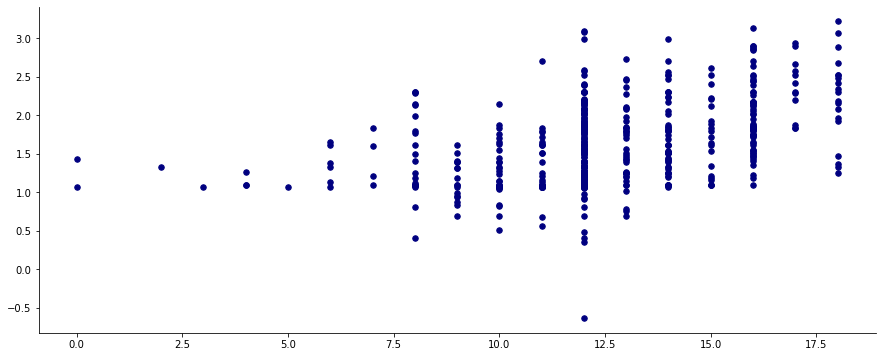

In [17]:
#2
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(wage['educ'],wage['lwage'],color='navy', s=30) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [19]:
#3
prac_results = smf.ols('lwage ~ educ', data=wage).fit()
print(prac_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     119.6
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           3.27e-25
Time:                        13:35:44   Log-Likelihood:                -359.38
No. Observations:                 526   AIC:                             722.8
Df Residuals:                     524   BIC:                             731.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5838      0.097      5.998      0.0

## More Data transformations
Statsmodels can handle common (and less common) regression tasks. Here are a few more. You can always check the documentation for more!

#### Interacting variables
Use `*` to interact two variables. Patsy will also **include the two variables individually**. Let's interact education and age. The model is now

$$ sleep = \beta_0 + \beta_1 totwrk + \beta_2 educ + \beta_3 age + \beta_4 age\times educ + \epsilon. $$

which is 

```python
'sleep ~ totwrk + educ*age'
```

Notice that I did not include education and age separately. 

In [20]:
res = smf.ols('sleep ~ totwrk + educ*age', data=sleep).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.119
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     23.67
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           2.24e-18
Time:                        13:36:49   Log-Likelihood:                -5260.9
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     701   BIC:                         1.055e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3081.4242    286.426     10.758      0.0

#### Fixed effects
When I was a kid, we called these dummy variables. Gender is coded {0,1} in the variable 'male'. Stats models uses the syntax `C()` where the `C` is a mnemonic for 'categorical.' 

In [21]:
# Take a peek at 'male'. It's zeros and ones. 
sleep['male'].head()

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: male, dtype: float32

By adding a fixed effect for gender, the model is 

$$ sleep = \beta_0 + \beta_1 totwrk + \beta_2 educ + \beta_3 age + \beta_4 I(\text{male}=1) + \epsilon. $$

where $I(\text{male}=1)$ is an indicator function that is equal to one if 'male' is equal to one. The model syntax is 

```python
sleep ~ totwrk + educ + age + C(male)
```

In [22]:
res = smf.ols('sleep ~ totwrk + educ + age + C(male)', data=sleep).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     24.26
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           8.02e-19
Time:                        13:38:03   Log-Likelihood:                -5259.8
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     701   BIC:                         1.055e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       3642.4666    111.844     32.

The 'T.1.0' notation is a bit confusing in this context. It means it is giving the value for coefficient on the 'male'=1.0 variable. Since we have included a constant, one of the categories gets dropped. In this case, the intercept is the 'male'=0 case. 

To see things more clearly, let's recode the male variable. 

In [23]:
sleep['gender'] = sleep['male'].replace({1.0:'male', 0.0:'female'})

res = smf.ols('sleep ~ totwrk + educ + age + C(gender)', data=sleep).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  sleep   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.117
Method:                 Least Squares   F-statistic:                     24.26
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           8.02e-19
Time:                        13:41:46   Log-Likelihood:                -5259.8
No. Observations:                 706   AIC:                         1.053e+04
Df Residuals:                     701   BIC:                         1.055e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          3642.4666    111.84

## Practice

Take a few minutes and try the following. Feel free to chat with those around you if you get stuck. The TA and I are here, too. 

We will continue with the example from before (Wooldridge problem C2 in chapter 6).

4. Scatter plot the residuals (y axis) against education (x axis). The residuals are in the results object from the fit method. 

In part 3. from the earlier exercise, I used 
```python
prac_results = smf.ols('np.log(wage) ~ educ', data=wage1).fit()
```

so the residuals are in `prac_results.resid`. Try inspecting `prac_results.resid` first. What kind of object is it?

In [24]:
wage.head(2)

,wage,educ,exper,tenure,nonwhite,female,married,numdep,smsa,northcen,...,trcommpu,trade,services,profserv,profocc,clerocc,servocc,lwage,expersq,tenursq
0,3.10,11.0,2.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.131402,4.0,0.0
1,3.24,12.0,22.0,2.0,0.0,1.0,1.0,3.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.175573,484.0,4.0


In [26]:
type(prac_results.resid)

pandas.core.series.Series

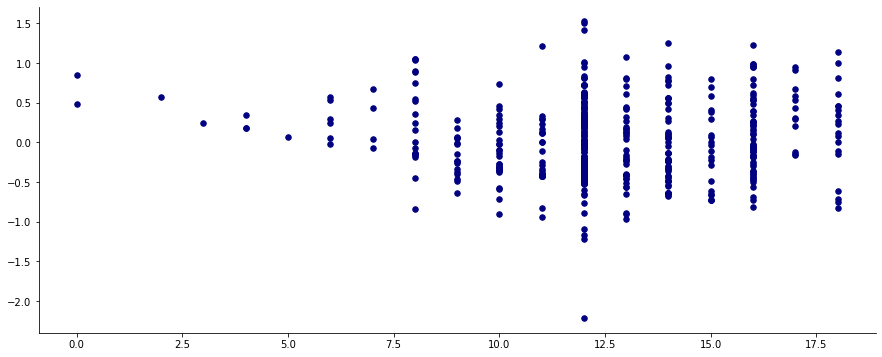

In [25]:
#4
fig, ax = plt.subplots(figsize=(15,6))
ax.scatter(wage['educ'],prac_results.resid ,color='navy', s=30) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

5. Looks heteroskedastic. We can change the covariance matrix type (which will correct the standard error calculation) using the `cov_type` parameter [(docs)](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.OLS.fit.html#statsmodels.regression.linear_model.OLS.fit). The types of covariance matrices are described in the [docs](https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html).

Try 'HC3' for your covariance matrix type.

Note: If you have not had econometrics yet, this probably doesn't make much sense to you. That's okay&mdash;just skip it. 

In [27]:
#5
prac_results_h3 = smf.ols('lwage ~ educ', data=wage).fit(cov_type='HC3')
print(prac_results_h3.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.186
Model:                            OLS   Adj. R-squared:                  0.184
Method:                 Least Squares   F-statistic:                     111.7
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           8.48e-24
Time:                        13:47:55   Log-Likelihood:                -359.38
No. Observations:                 526   AIC:                             722.8
Df Residuals:                     524   BIC:                             731.3
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5838      0.099      5.872      0.0

6. Let's add some more regressors. Estimate
$$ \log(wage) = \beta_0 + \beta_1 educ + \beta_2 exper + \beta_3 exper^2 + \beta_4I_m + \epsilon$$

where $I_m$ is a variable equal to 1 if the worker is a married.

In [31]:
#6
prac_results_6 = smf.ols('lwage ~ educ + exper + np.power(exper,2) + C(married)', data=wage).fit()
print(prac_results_6.summary())

                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     58.44
Date:                Mon, 29 Nov 2021   Prob (F-statistic):           9.59e-41
Time:                        13:53:21   Log-Likelihood:                -315.96
No. Observations:                 526   AIC:                             641.9
Df Residuals:                     521   BIC:                             663.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1427      0

### Plotting the regression line 

Recall that seaborn gives us an easy way to compute a regplot but will not give us the coefficients of the regression line. Here, we explore how to compute the regression and plot the line. The pros: we know exactly what regression we are using and we can control it. Cons: its more coding. This is the usual tradeoff of doing more work to ensure that we understand exactly what is being done. 

In a two-variable regression (or in a scatter plot) we can plot the regression line. We use the data and the estimated coefficients. The estimated coefficients are in the results object `params`. 

If you finish early, try these next two problems on your own (don't look at my code). We will go through them in class together. 

7. Scatter plot the data (this is the same as part 2.) and add the regression line for the model

$$log(y) = \beta_0 + \beta_1 edu + \epsilon.$$

Again, this is the regression from part 3. You might still have the results in `prac_results`.


To plot the regression line you will need to create some x data and then apply the parameters. I used something like this
```python
y = [p.Intercept + p.educ*i for i in x]
```
where `p` hold the parameters from my results and x holds a few x data points. 

In [33]:
# Just in case we changed some stuff above, re-run the regression.
prac_results = smf.ols('np.log(wage) ~ educ', data=wage).fit()

In [34]:
# Create the line of best fit to plot
p = prac_results.params                                # params from the model fit
print(p)
print(type(p))

Intercept    0.583773
educ         0.082744
dtype: float64
<class 'pandas.core.series.Series'>


In [35]:
# I'm drawing a line, so I only need two points. 
x = [wage['educ'].min(), wage['educ'].max()]

y = [p.Intercept + p.educ*i for i in x]    

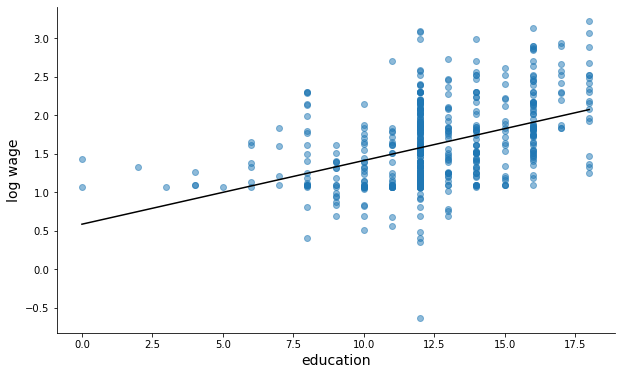

In [37]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the data
ax.scatter(wage['educ'], wage['lwage'], marker='o', alpha = 0.5 )

# Plot the regression line.
ax.plot(x,y, color='black')

ax.set_xlabel('education', fontsize=14)
ax.set_ylabel('log wage', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

8. Add the equation for the regression line to the figure. 

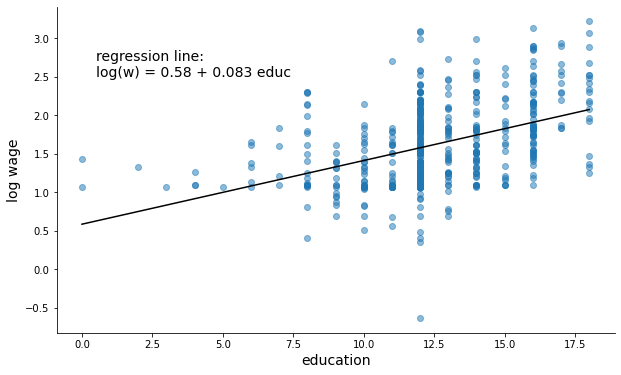

In [38]:
fig, ax = plt.subplots(figsize=(10,6))

# Plot the data
ax.scatter(wage['educ'], wage['lwage'], marker='o', alpha = 0.5 )
# Plot the regression line.
ax.plot(x,y, color='black')

# build the string
text = 'regression line: \nlog(w) = {0:.2} + {1:.2} educ'.format(p.Intercept, p.educ)

ax.text(0.5, 2.5, text, fontsize=14)

ax.set_xlabel('education', fontsize=14)
ax.set_ylabel('log wage', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)